## Revision History

Update with your details here

Name: Abhinav Rohilla

Date: 26/Nov/2021

## Basic problem statement 
Explore, understand and build on what factors influence energy consumption – for appliances and light - using the provided data for a house in Belgium. 

If it is feasible and/or required to build a model 
- can you outline the approach, 
- build a proof of concept model with the available data and 
- architect a scenario where/how the model could be used. 

Please answer below questions based on your understanding
- How can we improve this perceived system?
- what challenges do you see in deploying this system?
- can you propose a timeline based on this PoC for this development?

Please use the notebook to record your thought process and code. Once you have performed the assessment, respond back with your solution in 5 days. You will be required to walk through the notebook in a technical discussion. 

A basic workflow is defined via code comments, which you may use. Please ensure to include your references in the last cell. 

## Data Set Information

The data set is at 10 min for about 4.5 months. The house temperature and humidity conditions were monitored with a ZigBee wireless sensor network. Each wireless node transmitted the temperature and humidity conditions around 3.3 min. Then, the wireless data was averaged for 10 minutes periods. The energy data was logged every 10 minutes with m-bus energy meters. Weather from the nearest airport weather station (Chievres Airport, Belgium) was downloaded from a public data set from Reliable Prognosis (rp5.ru), and merged together with the experimental data sets using the date and time column.

Data repository : [link](http://archive.ics.uci.edu/ml/machine-learning-databases/00374/energydata_complete.csv)

## Attribute Information
* date : time year-month-day hour:minute:second
* Appliances, energy use in Wh 
* lights, energy use of light fixtures in the house in Wh 
* T1, Temperature in kitchen area, in Celsius 
* RH_1, Humidity in kitchen area, in % 
* T2, Temperature in living room area, in Celsius 
* RH_2, Humidity in living room area, in % 
* T3, Temperature in laundry room area 
* RH_3, Humidity in laundry room area, in % 
* T4, Temperature in office room, in Celsius 
* RH_4, Humidity in office room, in % 
* T5, Temperature in bathroom, in Celsius 
* RH_5, Humidity in bathroom, in % 
* T6, Temperature outside the building (north side), in Celsius 
* RH_6, Humidity outside the building (north side), in % 
* T7, Temperature in ironing room , in Celsius 
* RH_7, Humidity in ironing room, in % 
* T8, Temperature in teenager room 2, in Celsius 
* RH_8, Humidity in teenager room 2, in % 
* T9, Temperature in parents room, in Celsius 
* RH_9, Humidity in parents room, in % 
* To, Temperature outside (from Chievres weather station), in Celsius 
* Pressure (from Chievres weather station), in mm Hg 
* RH_out, Humidity outside (from Chievres weather station), in % 
* Wind speed (from Chievres weather station), in m/s 
* Visibility (from Chievres weather station), in km 
* Tdewpoint (from Chievres weather station), in Deg C

# Approach used

1. As it will be a time series forecasting, we'll be using "Appliances" feature as the target variable.
2. After data preprocessing new auto regressive and moving averages features will be added.
3. I will be using Supervised model to fit this data
4. After fitting the data, model will able to predict energy consumption in a time period
5. From that model if we calculate feature importances, we will get to know what factors/features are influencing energy consumption

In [1]:
## The libraries you use
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from mlxtend.evaluate import bias_variance_decomp
import graphviz
from sklearn import tree
from sklearn.tree import export_graphviz


In [2]:
data = pd.read_csv("/Users/abhinavrohilla/Downloads/energydata_complete (1).csv")

In [3]:
data['date'] = pd.to_datetime(data['date'])

In [4]:
data.isnull().sum()
#No null values

date           0
Appliances     0
lights         0
T1             0
RH_1           0
T2             0
RH_2           0
T3             0
RH_3           0
T4             0
RH_4           0
T5             0
RH_5           0
T6             0
RH_6           0
T7             0
RH_7           0
T8             0
RH_8           0
T9             0
RH_9           0
T_out          0
Press_mm_hg    0
RH_out         0
Windspeed      0
Visibility     0
Tdewpoint      0
rv1            0
rv2            0
dtype: int64

<AxesSubplot:xlabel='date', ylabel='Appliances'>

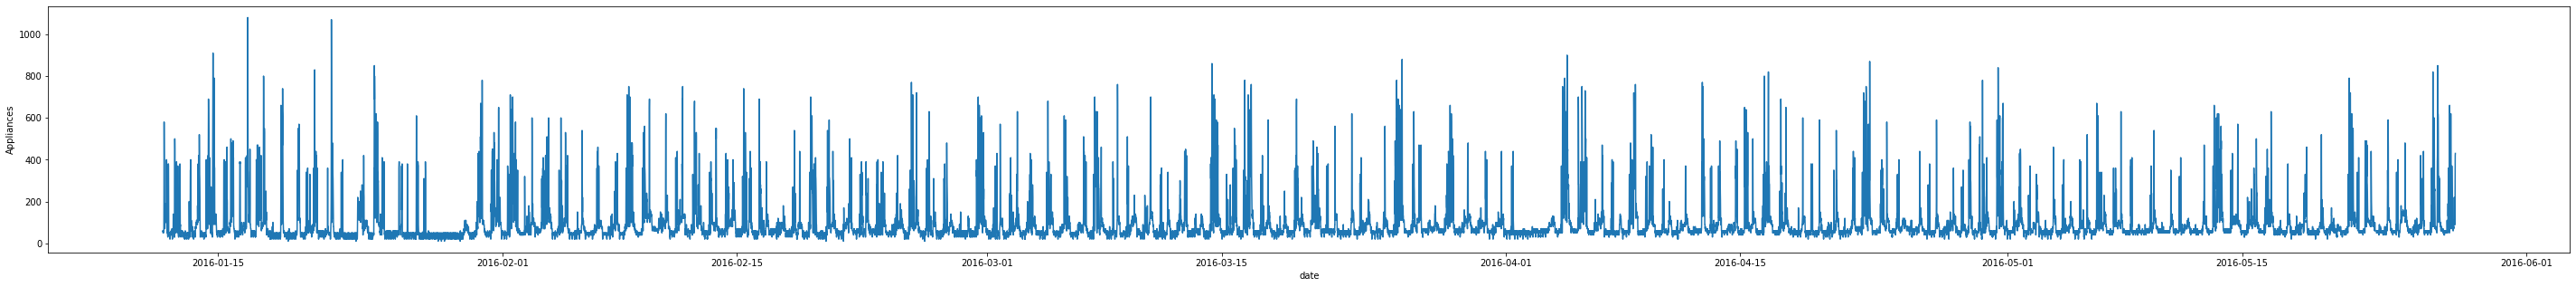

In [5]:
plt.figure(figsize=(50,5))
sns.lineplot(x="date", y="Appliances", data=data)


In [6]:
#Adding new feature called Home_temperatue and home_humidity, which will be mean temp/humidity of all rooms

data['home_temp'] = data[['T1','T2','T3','T4','T5','T6','T7','T8','T9']].mean(axis=1)
data['home_humdity'] = data[['RH_1','RH_2','RH_3','RH_4','RH_5','RH_6','RH_7','RH_8','RH_9']].mean(axis=1)


<AxesSubplot:xlabel='date', ylabel='lights'>

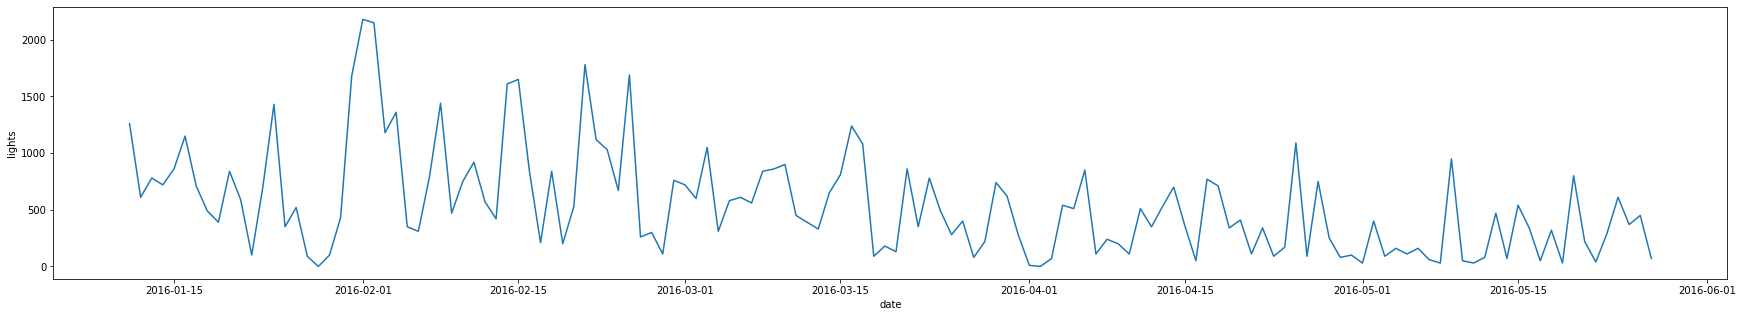

In [7]:
#Plotting sum of enrgy used by Lights in a day
plt.figure(figsize=(30,5))
sns.lineplot(x="date", y="lights", data=data.groupby(data['date'].dt.date).sum())
#On average usuage of light can be seen more in early months of year, than mid year 

<AxesSubplot:xlabel='date', ylabel='Appliances'>

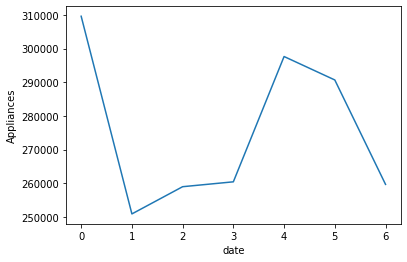

In [8]:
#Energy consumption based on weekdays
sns.lineplot(x="date", y="Appliances", data=data.groupby(data['date'].dt.weekday).sum())
#0 - Monday, 6 - Sunday
#Energy consumption is very high on Monday's, Lowest on Tuesdays, followed by Sunday
#High consumption can be seen on Friday too

<AxesSubplot:xlabel='date', ylabel='Appliances'>

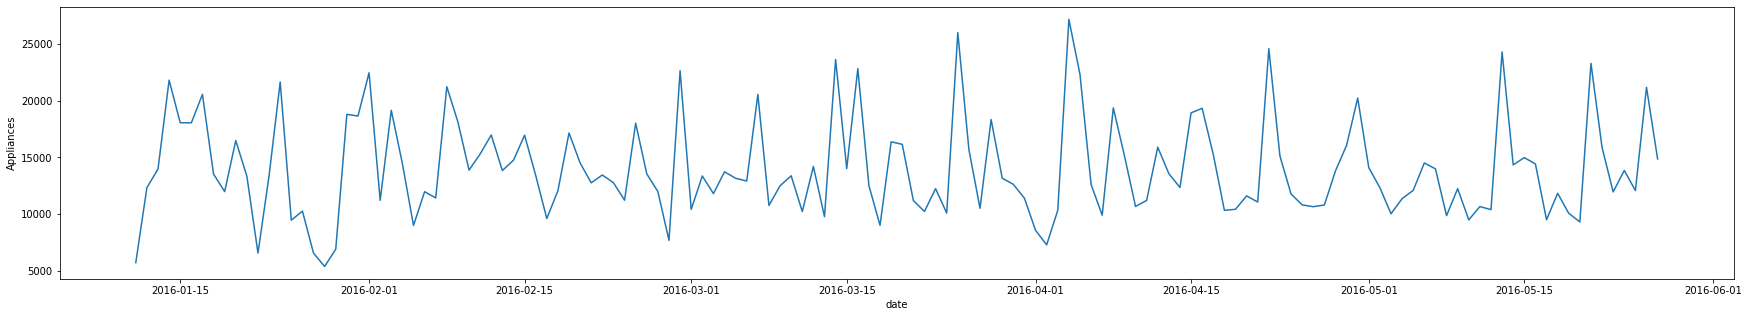

In [9]:
#Total Energy consumption based on date
plt.figure(figsize=(30,5))
sns.lineplot(x="date", y="Appliances", data=data.groupby([data['date'].dt.date]).sum())
#No such pattern can be seen in here

<AxesSubplot:xlabel='date', ylabel='home_temp'>

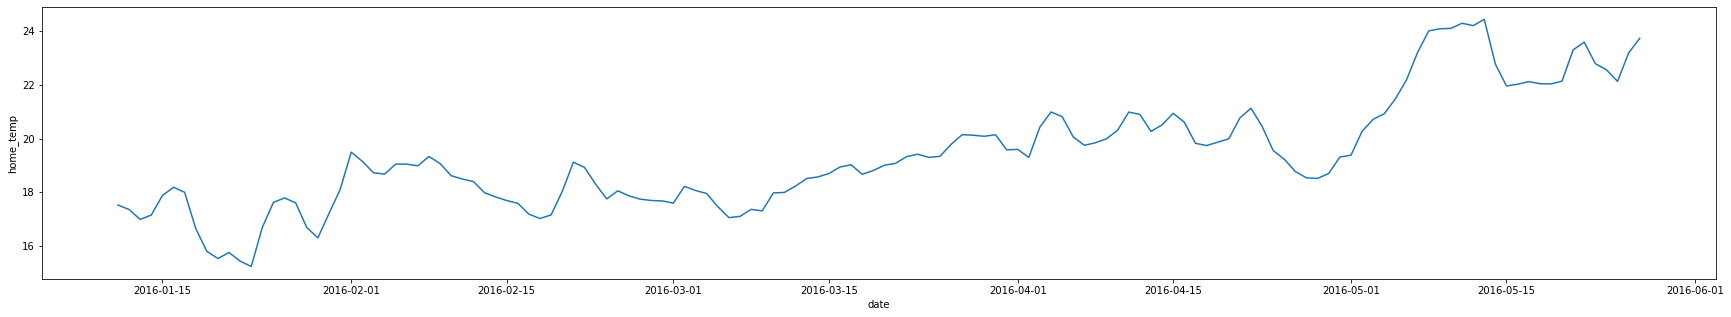

In [10]:
#Average home temperature, group by on date
plt.figure(figsize=(30,5))
sns.lineplot(x="date", y="home_temp", data=data.groupby([data['date'].dt.date]).mean())
#Average home temperature increases as we move towards mid year
#More energy is consumed in summers than winters

<AxesSubplot:xlabel='date', ylabel='home_humdity'>

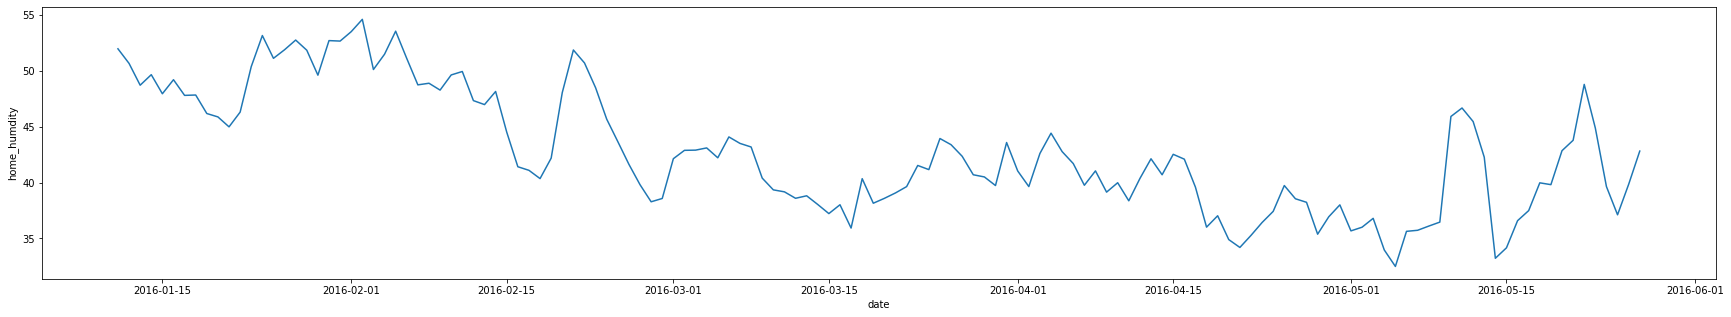

In [11]:
#Average home humidity, group by on date
plt.figure(figsize=(30,5))
sns.lineplot(x="date", y="home_humdity", data=data.groupby([data['date'].dt.date]).mean())
#humidity on average seems to be decreasing as summer arrive, though it have some siginificant spikes in 
#early may and mid may

<AxesSubplot:xlabel='date'>

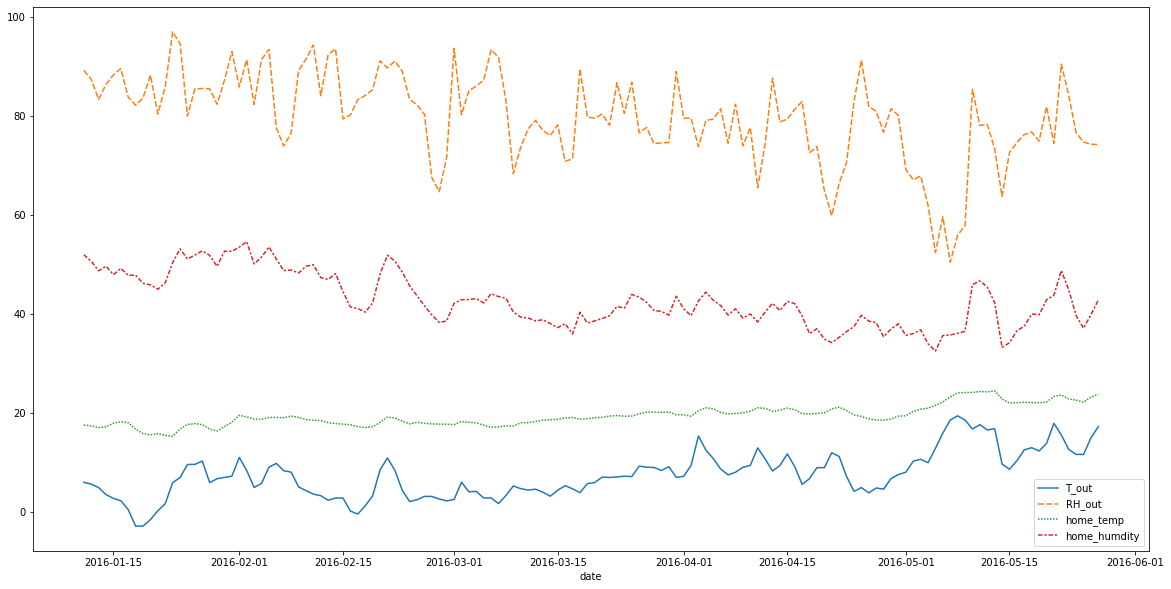

In [12]:
plt.figure(figsize=(20,10))
sns.lineplot(data = data.groupby([data['date'].dt.date]).agg({'T_out':'mean','RH_out':'mean', 'home_temp':'mean','home_humdity':'mean'}))
#Comparing temperatures in/out home by taking average energy consumption of the day
#Home temperature and home humidity seems constant with low fluctuations but T_out and RH_out have
#high fluctuations and quite uncertain.

In [13]:
features_to_preprocessed = ['lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3',
       'RH_3', 'T4', 'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8',
       'RH_8', 'T9', 'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed',
       'Visibility', 'Tdewpoint', 'rv1', 'rv2']

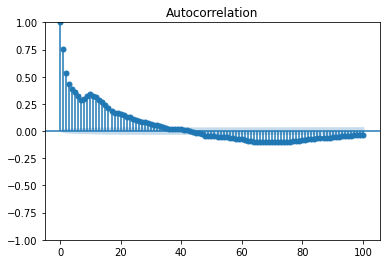

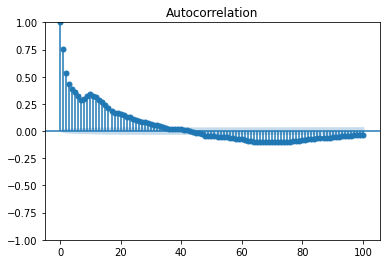

In [14]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(data['Appliances'], lags = 100)
#This function calculates correlation with new features with lags, so if I give lags 100, there
#will be 100 features created with increasing number of lags
#Interesting spike can be seen around lag 10-11, which means there is some seasonality/correlation after 
#every 100 minutes(1.6 hours)
#nearly no correlation is seen at lag 40 i.e 400 minutes(6.6 hours)
#After lag 40 negative correlation is seen for further lagged features

#### Similar analysis can be done for other features like T0, T1, RH_0, RH_1 etc. and new features can be calculated
There we need to calculate correlation of lag features with dependent variable.
The Lag feature which will have high correlation with dependent variable, will be added in modelling.

In [15]:
#From above graph we will be taking lag for 10 minutes, 20 minutes, 30 minutes, 100 minutes
#We can choose from negative correlation too, but we will be loosing data there.
data['Appliances_lag_1'] = data['Appliances'].shift(1)
data['Appliances_lag_2'] = data['Appliances'].shift(2)
data['Appliances_lag_3'] = data['Appliances'].shift(3)
data['Appliances_lag_4'] = data['Appliances'].shift(10)


In [16]:
#Adding moving averages
#Adding average of previous 20 minutes energy consumption to each record
data['Appliances_MA_1'] = data['Appliances'].rolling(2).mean().shift(1).reset_index(0,drop=True)
data['Appliances_MA_2'] = data['Appliances'].rolling(3).mean().shift(1).reset_index(0,drop=True)
data['Appliances_MA_3'] = data['Appliances'].rolling(4).mean().shift(1).reset_index(0,drop=True)
data['Appliances_MA_4'] = data['Appliances'].rolling(11).mean().shift(1).reset_index(0,drop=True)

In [17]:
#Adding Trend features i.e differences from previous time frames
diff = data['Appliances'] - data['Appliances'].shift(1)
data['Appliances_diff'] = diff.shift(1)

In [18]:
data['week'] =data['date'].dt.week

/var/folders/ph/cj02fyh11yd4qxj56qsnf6w00000gn/T/ipykernel_9269/2871323319.py:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  data['week'] =data['date'].dt.week


In [19]:
#Just like this we can further create more features using statistics from previous time frames
# for examples, we can use Min or Max Appliance consumption from last N hours.

In [20]:
data = data.set_index('date')

In [21]:
data = data.fillna(0)

"\nInsights from Heatmap\nOur main intention from heatmap is to drop independent features which are highly \ncorrelated among themselves and keep those features which are \nhighly correlated with target variable, in this case 'Appliances' is the target variable\n\n1. Temperature in rooms are coorelated with each other with different rooms, but less correlation with T6, \ni.e temperature outside the building\n2. All temperatures in rooms have high negative correlation with RH_6, ie humidity outside building\n3. RH_6 and RH_out are correlated, which makes sense because RH_6 is humidity outside the house\n4. Lagged feature and Moving averages of Appliances have high correlation with Appliances, correlation decreases\nas lag increases, so there is no point on adding more lagged features for Appliances\n"

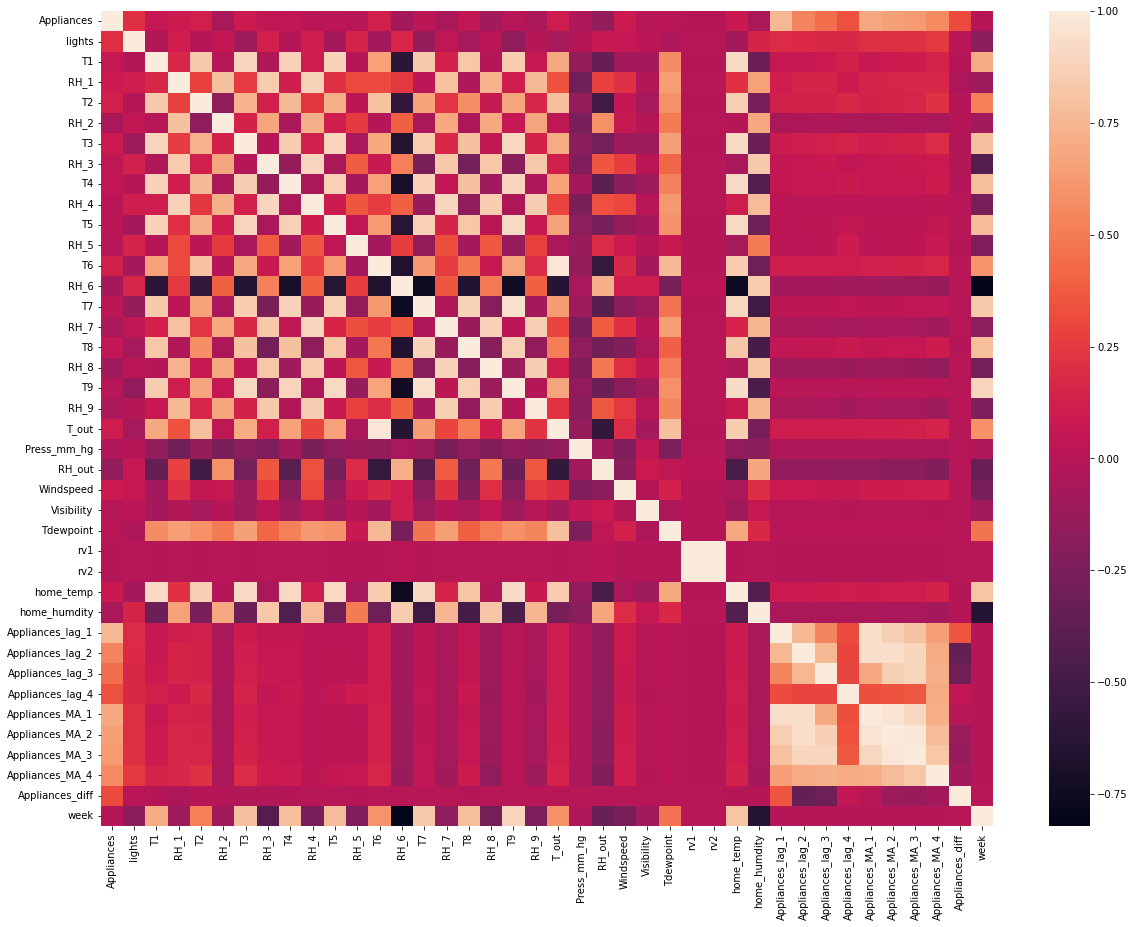

In [22]:
plt.figure(figsize=(20,15))

sns.heatmap(data.corr())

"""
Insights from Heatmap
Our main intention from heatmap is to drop independent features which are highly 
correlated among themselves and keep those features which are 
highly correlated with target variable, in this case 'Appliances' is the target variable

1. Temperature in rooms are coorelated with each other with different rooms, but less correlation with T6, 
i.e temperature outside the building
2. All temperatures in rooms have high negative correlation with RH_6, ie humidity outside building
3. RH_6 and RH_out are correlated, which makes sense because RH_6 is humidity outside the house
4. Lagged feature and Moving averages of Appliances have high correlation with Appliances, correlation decreases
as lag increases, so there is no point on adding more lagged features for Appliances
"""

'\n1. Appliances_MA_1 and Appliances_lag_1 are highly correlated with dependent variable ie. Appliances\nhence these can be important features for the model, it makes sense because it becomes important to predict\nenergy consumption if we know the consumption of last 10 minutes or last n minutes.\n'

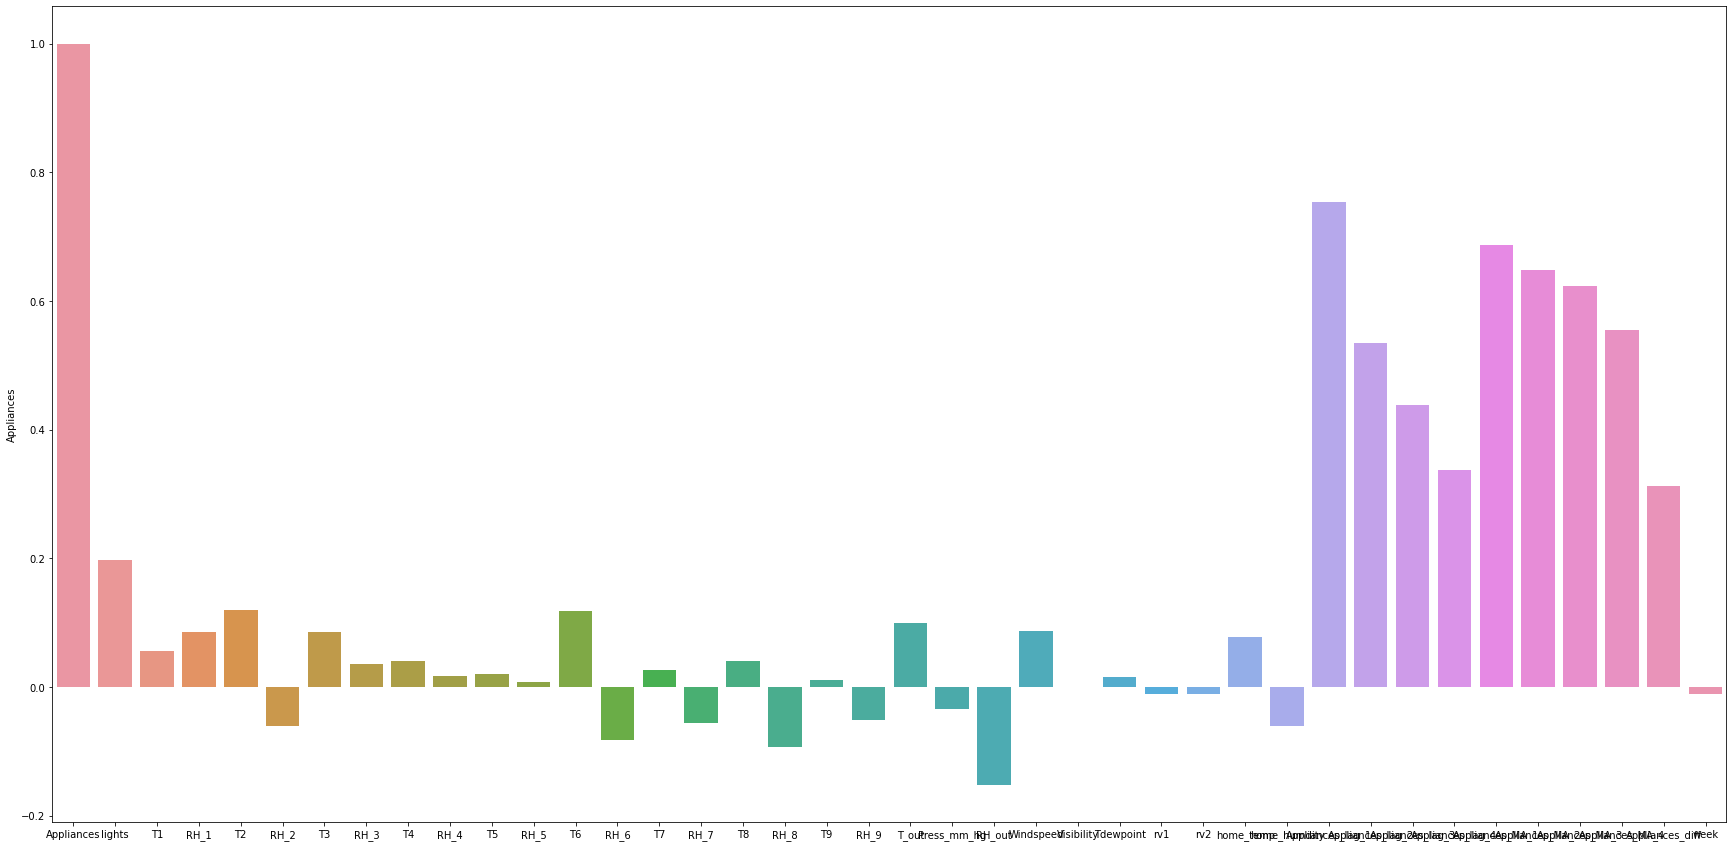

In [23]:
#Plotting correlation numbers WRT Appliances
plt.figure(figsize=(30,15))
sns.barplot(x=data.corr()['Appliances'].index,y=data.corr()['Appliances'])
"""
1. Appliances_MA_1 and Appliances_lag_1 are highly correlated with dependent variable ie. Appliances
hence these can be important features for the model, it makes sense because it becomes important to predict
energy consumption if we know the consumption of last 10 minutes or last n minutes.
"""

In [24]:
#Using Timeseriessplit because using train_test_split can shuffle training data
tscv = TimeSeriesSplit()

In [25]:
scaler = MinMaxScaler()
clf = RandomForestClassifier()
clf1 = LinearRegression()
clf2 = DecisionTreeClassifier()

In [26]:
index = 1
for train_index, test_index in tscv.split(data):
    train = data.iloc[train_index]
    test = data.iloc[test_index]
    print('Observations: %d' % (len(train) + len(test)))
    print('Training Observations: %d' % (len(train)))
    print('Testing Observations: %d' % (len(test)))
    
    X_train, y_train = train.drop("Appliances", axis=1), train['Appliances']
    X_test, y_test = test.drop("Appliances", axis=1), test['Appliances']
    
    X_train_scaler = scaler.fit_transform(X_train)
    X_test_scaler = scaler.fit_transform(X_test)
    print ("TRAINING")
    clf2.fit(X_train_scaler, y_train)
    
    y_preds = clf2.predict(X_test_scaler)
    
    print ("MAE",mean_absolute_percentage_error(y_test, y_preds))
    print ("=====================================================================>>>>>>>>>>>>>>>>>")
#     plt.subplot(310 + index)
#     plt.plot(train)
#     plt.plot([None for i in train] + [x for x in test])
    index += 1
# plt.show()


Observations: 6579
Training Observations: 3290
Testing Observations: 3289
TRAINING
MAE 0.8107076002673375
=====================================================================>>>>>>>>>>>>>>>>>
Observations: 9868
Training Observations: 6579
Testing Observations: 3289
TRAINING
MAE 0.5922362879167582
=====================================================================>>>>>>>>>>>>>>>>>
Observations: 13157
Training Observations: 9868
Testing Observations: 3289
TRAINING
MAE 0.3552938844193824
=====================================================================>>>>>>>>>>>>>>>>>
Observations: 16446
Training Observations: 13157
Testing Observations: 3289
TRAINING
MAE 0.3558797065178831
=====================================================================>>>>>>>>>>>>>>>>>
Observations: 19735
Training Observations: 16446
Testing Observations: 3289
TRAINING
MAE 0.35184034481741716
=====================================================================>>>>>>>>>>>>>>>>>


### Model's mean absolute error is already low in DecisionTree, to reduce it further we can use RandomForrest classifier.
But it might affect time complexity.
With Linear regression MAE was quite high which shows high variance and low bias, so had to use more complex model
RandomForrest will definetely reduce MAE as it reduces variance error from DecisionTree.
I am prioritizing Tree models as it's explainability is easier than other complex models

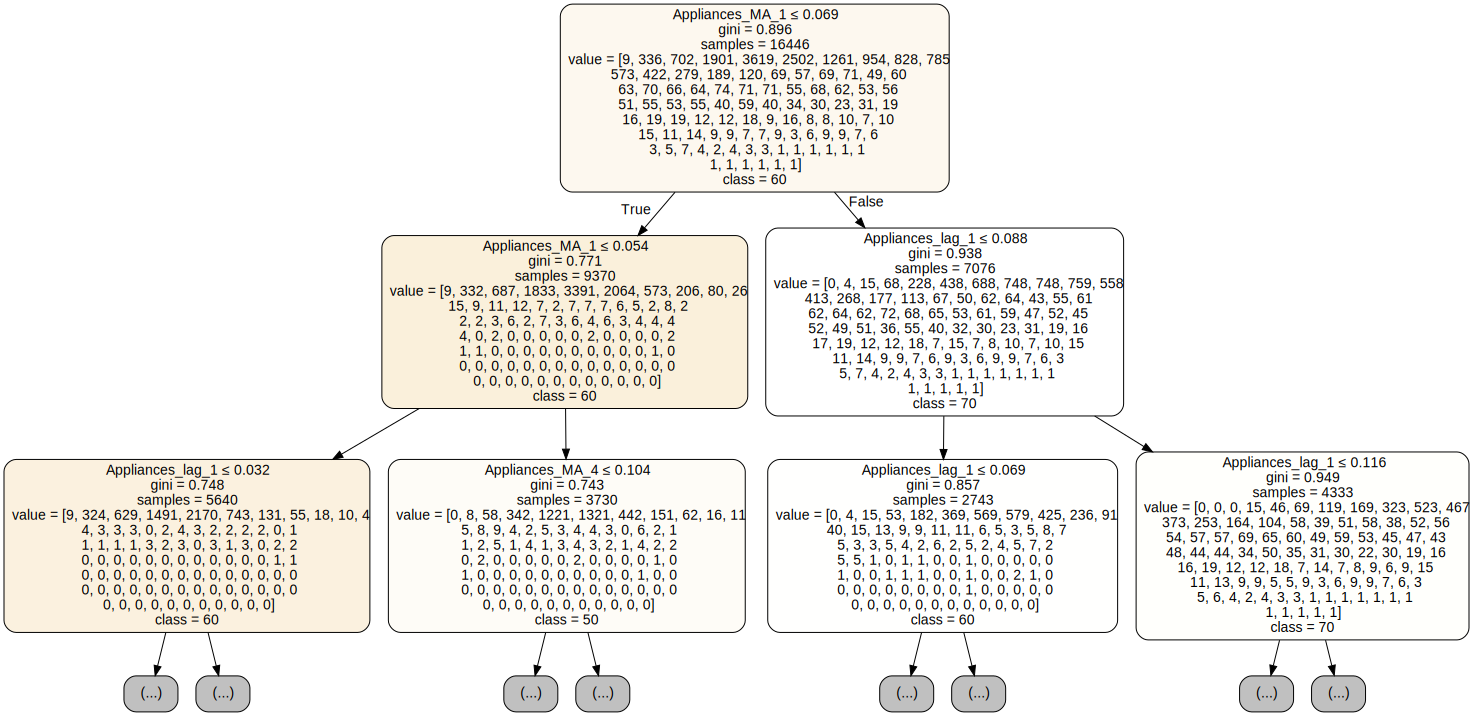

In [27]:
"""
Plotting Decision tree to decode what's happening at the backend.
So according to decision tree Appliances MA 1 is the most important feature as it got the best split from Gini index.
Next Splits is on "Appliances_lag_1".
We can remove normalization and get the real values and we can get the threshold value on which it got highest entropy
"""
dot_data = tree.export_graphviz(clf2, 
                  feature_names=X_train.columns,  
                  class_names=[str(i) for i in y_train],  
                  filled=True, rounded=True,  
                  special_characters=True,
                   out_file=None,max_depth=2
                           )
graph = graphviz.Source(dot_data)
graph

<BarContainer object of 39 artists>

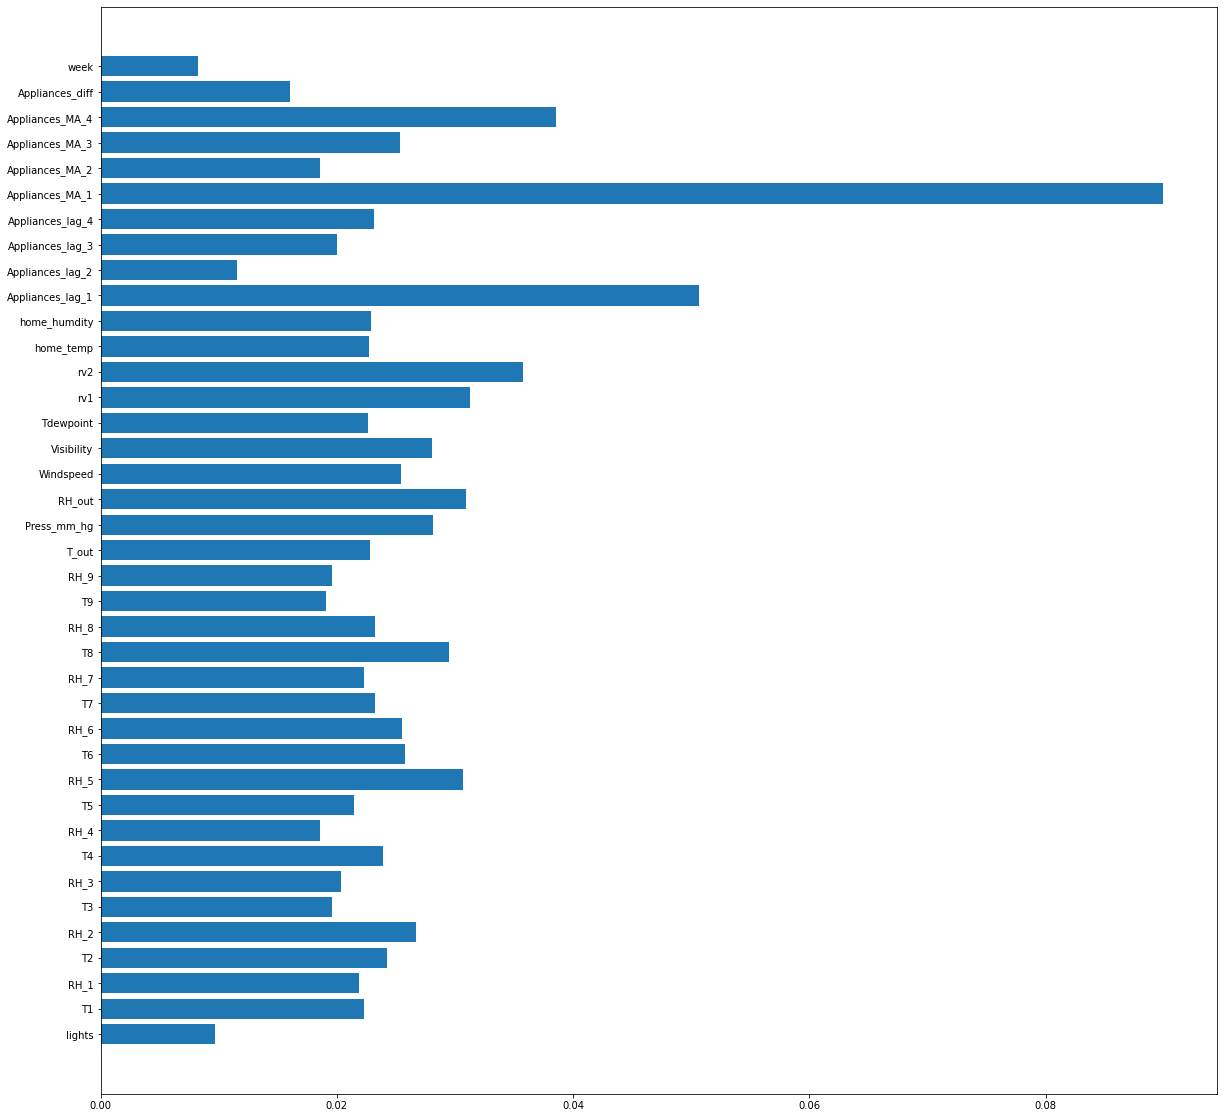

In [28]:
#Or simply we can just plot feature importances offered by DecisionTree
plt.figure(figsize=(20,20))
plt.barh(X_train.columns, clf2.feature_importances_)

# Factors influencing energy consumption

1. Appliances_MA_1 - It is important to know the average consumption in last 20 minutes, as it highly depends on predicting energy consumption.
2. Appliance_lag_1 - last 10 minutes consumption is another factor helps in determining energy consumption
3. Appliance_MA_4
4. RV1 and RV2 also play significant importance in predicting energy consumption
5. RH_out(Humidity outside), T8(Temperature in Teenager room) and RH5(Humidity in Bathroom) are also marked as important features
6. Lights does not affect energy consumption as it got less importance score

# How can we improve this perceived system?

1. Work needs to done in feature engineering. I have only added Auto-regressive features of Target variable(Appliances_lag1, Appliances_lag2, Appliances_MA1, Appliances_MA2 etc.) but we can also add more such features for all independent variables. For example we can add lag features for T0, T1, T2 etc. Plotting Auto-correlation for them and deciding which features to add.
2. Improve modeling using Auto-ML or hyper-parameter tuning.
3. We can use pre-built models like ARIMA(Auto regressive Integrated moving average) which will have better features and accuracy. 

# What challenges do you see in deploying this system?

1. Data issues - For forecasting future data, we need more historical data aligned, we only have data for 4.5 months, we might need more data to understand seasonal affects in whole year, forecasting can be biased to these 5 months.
2. Factors influencing energy consumption can change in few days, model needs to train after specific period of days, maybe daily, so a cron job needs to scheduled which can be costly at some point of time.
3. After a certain point of time, model will be trained on huge data as data is being collected daily, in such case training model can take longer time and hence delay in results
4. Cloud Architecture should be decoupled so that if a service stops working, it does not affect other services, for this queueing and serverless architecture should be considered.
5. Forecast generated from a model may not be accurate when applied to future data, length of frequency of seasonal patterns may expand or contract as we go in future.

# Can you propose a timeline based on this PoC for this development?

Timeline is based on delivering this product end-to-end from scratch.

1. Building data collection pipeline from data engineers. This will take time as process needs to be decoupled and verified. Depends on how many developers are working on it. Assuming 3(2.5 months)
2. MLOps and Devops building AWS infra(Governance and security etc.) (10-15 days)
3. Convert PoC to productionized code(20 days)
4. Deployment and unit testing(5-10 days)
5. Adding buffer(5 days)

#### Total - 4 months

In [29]:
## Read data and basic data clean-up

In [30]:
## strategy for missing value treatment

In [31]:
## Data exploration

In [32]:
## key insights

In [33]:
# feature engineering

In [34]:
# model feasibility

In [35]:
# model iterations and selection

In [36]:
# model explainability

## Summary and next steps

## References (add your references below)
[1] Luis M. Candanedo, Veronique Feldheim, Dominique Deramaix, Data driven prediction models of energy use of appliances in a low-energy house, Energy and Buildings, Volume 140, 1 April 2017, Pages 81-97, ISSN 0378-7788,

[2] Python documentation

[3] Sklearn documentation https://scikit-learn.org/

[4] Pandas https://pandas.pydata.org/

[5] Seaborn https://seaborn.pydata.org/